<a href="https://colab.research.google.com/github/SossouAdjisse/AmazonProductReviews/blob/main/AmazonProductsRecommendationProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--------------
--------------
# PROJECT:  Recommendation Systems: Amazon Product Reviews
###### **Sossou S Adjisse**
--------------
--------------
## Objective:
This exercise (project) aims to build Recommendation Systems using the Amazon product reviews dataset, which contains ratings of different electronic products. I will build different recommendation models (ranked-based, similarity-based, and model-based collaborative filterings) to provide personalized suggestions (products they are likely to buy) to different users on the Amazon E-commerce website based on their ratings on others products.  

--------------
## Dataset:


The Amazon dataset can be found [HERE](https://drive.google.com/drive/folders/1WfBl-D5jTixUcZ-TwzOiBqe5IcHhZonR?usp=sharing), and contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** Rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating (ignore this column for this exercise)

In [ ]:
# Mounting my google drive to google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing the necessary libraries

In [ ]:
# Installing Surprise Library
!pip install surprise

In [ ]:
# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# numpy library 
import numpy as np

# pandas library
import pandas as pd

# For plottings 
import matplotlib.pyplot as plt
import seaborn as sns

# surprise library 
from surprise import accuracy

# class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# class for loading datasets
from surprise.dataset import Dataset

# for model tuning model hyper-parameters
from surprise.model_selection import GridSearchCV

# for splitting the rating data in train and test dataset
from surprise.model_selection import train_test_split

# for implementing similarity based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# for implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

from collections import defaultdict

# for implementing cross validation
from surprise.model_selection import KFold

## Loading the Amazon product reviews dataset 

In [ ]:
# Import the electronics rating data by naming the columns 'user_id', 'item_id', 'rating', and 'timestamp'.
electronics = pd.read_csv('/content/drive/MyDrive/Portfolio/Amazon Product Reviews/ratings_Electronics.csv', names=['user_id', 'item_id', 'rating', 'timestamp'])

# Display the first 5 rows of the rating dataset
electronics.head()

,user_id,item_id,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [ ]:
# I will drop the 'timestamp' colomn as it will not be needed for the analyses
electronics = electronics.drop('timestamp', axis=1)

## Let's now explore the data a bit further


### Checking **various information** of the data

In [ ]:
electronics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   item_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


**Comments:**
- The data contains  **7,824,482 observations** and **3 columns**
- The only numeric variable is **rating** and there is no missing value


### **The variable rating is very important for our project going forwards and it is numeric. Therefore, it is useful to see what its distribution looks like.**

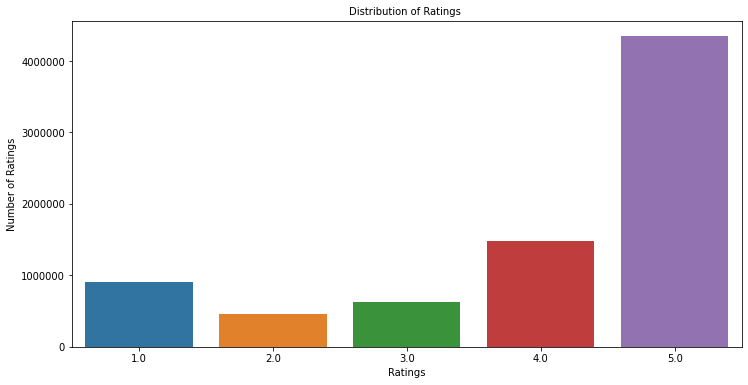

In [ ]:
plt.figure(figsize = (12, 6))
sns.countplot(x="rating", data=electronics)

plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.show()

In [ ]:
# Computing  the count of every rating
electronics.rating.value_counts(normalize=False)

5.0    4347541
4.0    1485781
1.0     901765
3.0     633073
2.0     456322
Name: rating, dtype: int64

**Comments:**
- Let's recall there are 7,824,482 observations in the data
- The rating 5 has the highest count (4,347,541) followed by 4 (1,485,781), then followed  by 1 (901,765), 3 (633,073), and lastly 2 (456,322)

- One stark remark is that the distribution is heavily more skewed to the left (1, 2, and 3) than the right (4 and 5).

### **Restricting the data**
Before moving forwards, I need to restrict the data for few raisons:

- First, the data has 7824482 observations, thus too large for the  computations required by the models I am going to build.

- Second, usually for rating datasets, there are many users who only rate a few products, and many products rated by very few users. 

- This makes it possible to reduce the dataset using some logical assumptions.

- Thus, I  will take users who have given at least 50 rating, and the products who has at least 5 rating.

#### **First restriction**

In [ ]:
# Get the column containing the users
users = electronics.user_id
# Create a dictionary from users to their number of ratings
ratings_count = dict()
for user in users:
    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1    

In [ ]:
# We want our users to have at least 50 ratings to be considred
RATINGS_CUTOFF = 50
remove_users = []
for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
electronics = electronics.loc[~electronics.user_id.isin(remove_users)]

In [ ]:
electronics.shape

(125871, 3)

**Comments:**
- After the first round of restriction, the data now dropped from **7,824,482** to **125,871** observations. This is a huge size reduction. 
- If I wanted the data size to be bigger than 125,871 I could set the cuttoff to any number lower than 50, 
- If I wanted a size lower than 125,871, I could increase the cutoff above 50. 

#### **Second restriction**

In [ ]:
# Get the column containing the users
users = electronics.item_id
# Create a dictionary from users to their number of ratings
ratings_count = dict()
for user in users:
    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1    

In [ ]:
# We want our item to have at least 5 ratings to be considred
RATINGS_CUTOFF = 5
remove_users = []
for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
electronics = electronics.loc[~electronics.item_id.isin(remove_users)]

In [ ]:
electronics.shape

(65290, 3)

**Comments:**
- The observations dropped now to **65,290** after the second round of restriction. 
- With this reasonable size, I am optimistic that the comptutaions will be not take forever to run. 

### **Further exploration of the restrained dataset**

#### **Total number of unique users, and total number of unique items**

In [ ]:
# Finding number of unique users
electronics['user_id'].nunique()

1540

In [ ]:
# Finding number of unique items
electronics['item_id'].nunique()

5689

**Comments:**
- The new data contains **1,540** unique users and **5,689** unique items
- So the total possible unique (user, item ) comples is **1540 * 5689 = 8761060**
- This means not every user has rated every item in the dataset because there are **only 65290 obs/ratings**.
- I can then build recommendation systems to recommend items to users which they have not interacted with.

#### **Checking if there is any item that has been interacted with more than once by the same user**

In [ ]:
# Checking the minimum interaction of a user of an item 
electronics.groupby(['user_id', 'item_id']).count()['rating'].min()

1

In [ ]:
# Checking the maximum interaction of a user of an item 
electronics.groupby(['user_id', 'item_id']).count()['rating'].max()

1

**Comments**

- Both the minum and the maximum interaction of a couple (user, item) is 1. 
- This means that **there is one and  only one interaction between a pair (user, item)**.

#### **The item which is the most interacted**

In [ ]:
electronics['item_id'].value_counts()

B0088CJT4U    206
B003ES5ZUU    184
B000N99BBC    167
B007WTAJTO    164
B00829TIEK    149
             ... 
B00368CDH6      5
B0036AZA6A      5
B0036E8V08      5
B0036QL1JY      5
B00LGQ6HL8      5
Name: item_id, Length: 5689, dtype: int64

**Comments:**

- **B0088CJT4U is the most interacted item by users** with **206** interactions in total.

#### **Distribution of ratings of the item B0088CJT4U**

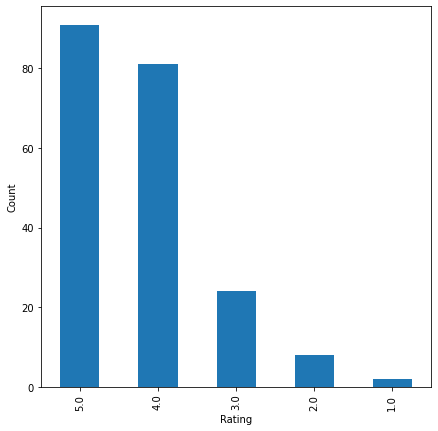

In [ ]:
plt.figure(figsize=(7,7))
electronics[electronics['item_id'] == 'B0088CJT4U']['rating'].value_counts().plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [ ]:
electronics[electronics['item_id'] == 'B0088CJT4U']['rating'].value_counts(normalize=False)

5.0    91
4.0    81
3.0    24
2.0     8
1.0     2
Name: rating, dtype: int64

**Comments:**

- The count of the ratings is decreasing from 5 to 1, with 5 and 4 beeing the highest. Thus, **the item B0088CJT4U is liked by most users**. 


#### **User who interacted the most with any item in the dataset**

In [ ]:
electronics['user_id'].value_counts()

ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
                 ... 
A16CVJUQOB6GIB      2
A2BGZ52M908MJY      2
A3DL29NLZ7SXXG      1
AP2NZAALUQKF5       1
A3MV1KKHX51FYT      1
Name: user_id, Length: 1540, dtype: int64

**Comments:**

- User **ADLVFFE4VBT8** has interacted with the most number of items with  **295** interactions. 

#### **Distribution of the user-item interactions in this dataset**

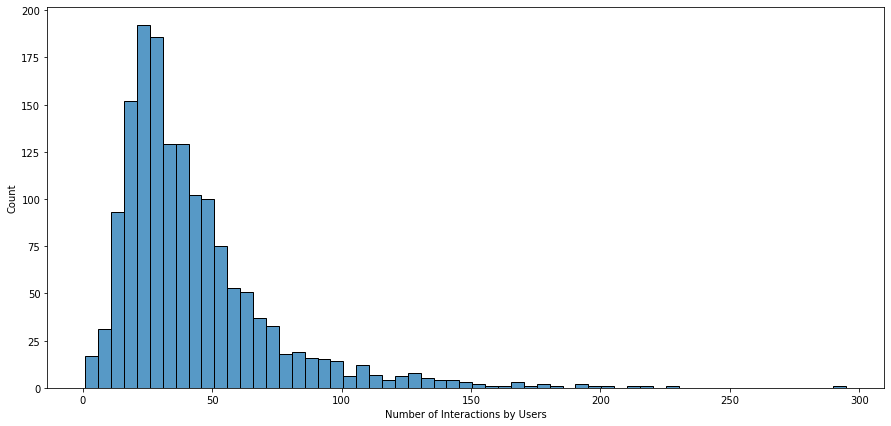

In [ ]:
# Computing the number of interaction per user
count_interactions = electronics.groupby('user_id').count()['item_id']

# Plotting user-item interactions distribution
plt.figure(figsize=(15,7))
sns.histplot(count_interactions)
plt.xlabel('Number of Interactions by Users')
plt.show()

**Comments:**
- As we can see, the user-item distribution is heavily skewed to the right. 
- This means that only a few users interacted with more than 50 items, which was the threshold I set earlier when restricting the data. 
- This also means I have plenty room of recommending items to constumers who have not rated them before.



## **Building Recommendation systems**

### **Model 1: Rank Based Recommendation System**

**Notes:**
- Rank-based recommendation systems provide recommendations based on the most popular items. 

- Take the **average** of all the ratings provided to each item and then rank them based on their average rating.

- Useful to solve  **cold start** problems, where new users get into the system and the machine is not able to recommend items to them due to the fact that they did not have any historical interactions in the dataset. 

In [ ]:
# Computing average ratings
average_rating = electronics.groupby('item_id').mean()['rating']

# Computing the count of ratings
count_rating = electronics.groupby('item_id').count()['rating']

# Making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

#### **Creating a function to find the top n items based on the average ratings, and setting up a threshold for a minimum number of interactions for an item to be considered for recommendation.**

In [ ]:
def top_n_items(data, n, min_interaction):
    
    # Finding items with minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]
    
    # Sorting values w.r.t average rating 
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)
    
    return recommendations.index[:n]

#### **Application: Recommending top 10 items with 30 minimum interactions based on popularity**

In [ ]:
list(top_n_items(final_rating, 10, 30))

['B0052SCU8U',
 'B001TH7T2U',
 'B00BQ4F9ZA',
 'B00IVFDZBC',
 'B001TH7GUU',
 'B001QUA6RA',
 'B00316263Y',
 'B008EQZ25K',
 'B003ES5ZUU',
 'B0000BZL1P']

**Comments:**
- These  items **'B0052SCU8U',  'B001TH7T2U B00BQ4F9ZA', 'B00IVFDZBC', 'B001TH7GUU', 'B001QUA6RA', 'B00316263Y', 'B008EQZ25K', 'B003ES5ZUU',** and **'B0000BZL1P'**  will be recommended to new users on the Amazon E-commerce website. 



### **Model 2: Collaborative Filtering Based Recommendation System**

**Notes:** 
- No need of information` about the users or items. 

- We only need user item interaction data to build a collaborative recommendation system. 

- Types of filtering: Similarity/Neighborhood-based and model-based

#### **Building similarity based recommendation system using `cosine` similarity and KNN to find similar users which are nearest neighbor to the given user.** 

##### **Loading the data into surprise.dataset.DatasetAutoFolds format**

In [ ]:

from sklearn.preprocessing import LabelEncoder
df=electronics[['user_id','item_id']].apply(LabelEncoder().fit_transform)
df['rating']=electronics['rating']
df.head()

,user_id,item_id,rating
1310,1050,0,5.0
1322,125,0,1.0
1335,785,0,3.0
1451,1495,0,5.0
1456,164,0,1.0


##### **Making the dataset into surprise dataset and splitting it into train and test set**

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df[['user_id', 'item_id', 'rating']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.7, random_state=42)

##### **Ready to build the first baseline similary based recommendation system using cosine similarity and KNN**

In [ ]:
sim_options = {'name': 'cosine',
               'user_based': True}

algo_knn_user = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the trainset, and predict ratings for the testset
algo_knn_user.fit(trainset)
predictions = algo_knn_user.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 1.0552


1.0551559636074466

**Comments:**

- The baseline model has **RMSE=1.05**` on test set
- I will try to improve this number later by using `GridSearchCV` to tun different hyperparameters of this algorithm

##### **Application 1: Predicting the  rating for the user with userId= 0 and for itemId= 3906, which the user has interacted with before**

In [ ]:
algo_knn_user.predict(0,3906, r_ui=4, verbose=True)

user: 0          item: 3906       r_ui = 4.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=0, iid=3906, r_ui=4, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Comments:**

- The actual rating for this user-item pair is 4 and predicted rating is 4.29 by the similarity based baseline model

##### **Application 2: Predicting rating for the same `userId= 0` but for an item `itemId=100`, which this user has not interacted before**

In [ ]:
algo_knn_user.predict(0,100, verbose=True)

user: 0          item: 100        r_ui = None   est = 4.00   {'actual_k': 1, 'was_impossible': False}


Prediction(uid=0, iid=100, r_ui=None, est=4.0, details={'actual_k': 1, 'was_impossible': False})

**Comments:**

- The estimated rating for this  user-item pair (user=0, item=100) is 4 based on this similarity based baseline model

##### **Improving similarity based recommendation system by tuning its hyper-parameters**

**Notes:**
- **k** (int) – The (max) number of neighbors to take into account for aggregation. 40 is the default number.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. 1 is the default.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise - 
    - cosine
    - msd (default)
    - pearson
    - pearson baseline
    

##### **Performing hyperparameter tuning for the baseline user based collaborative filtering recommendation system and finding the RMSE for tuned user based collaborative filtering recommendation system**

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9713673745769503
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


##### **Building the final model by using tuned values of the hyperparameters which we received by using grid search cross validation**

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized = KNNBasic(sim_options=sim_options, k=40, min_k=6,Verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized.fit(trainset)

# Predicting ratings for the testset
predictions = similarity_algo_optimized.test(testset)

# Computing RMSE on testset
accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9887


0.988698949219415

**Comments:**

- After tuning hyperparameters, RMSE for testset has reduced from 1.05 to 0.98 from 1.05. 
- Therefore the model has improved after hyperparameter tuning

##### **Predicted  rating for  userId=0 and for itemId= 3906 using this tuned/optimized user based collaborative filtering**

Let's us now predict rating for an user with `userId=0` and for `itemId=3906` with the optimized model as shown below

In [ ]:
similarity_algo_optimized.predict(0,3906, r_ui=4, verbose=True)

user: 0          item: 3906       r_ui = 4.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=0, iid=3906, r_ui=4, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Comments:**
- Both the baseline and the utned models predicted rating is `4.29`.

##### **Predicting rating for the same `userId=0` but for an item which this user has not interacted before i.e. `itemId=100`, by using the optimized model as shown below**

In [ ]:
similarity_algo_optimized.predict(0,100, verbose=True)

user: 0          item: 100        r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=0, iid=100, r_ui=None, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Comments:**
- The tuned model's predicted rating is `4.29`. Let's recall that the baseline's prediction was `4`.

##### **Identifying similar users (e.g. the 5 most similar user to userId=0)to a given user (nearest neighbors) based on msd distance metrci**

In [ ]:
similarity_algo_optimized.get_neighbors(0, k=5)

[7, 12, 14, 23, 47]

##### **Implementing the recommendation algorithm based on optimized KNNBasic model**

**Notes:** Below we will be implementing a function where the input parameters are - 

- data: a rating dataset
- user_id: an user id against which we want the recommendations
- top_n: the number of items we want to recommend
- algo: the algorithm we want to use to predict the ratings

In [ ]:
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating an empty list to store the recommended item ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='user_id', columns='item_id', values='rating')
    
    # Extracting those item ids which the user_id has not interacted yet
    non_interacted_items = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the item id which user_id has not interacted yet
    for item_id in non_interacted_items:
        
        # Predicting the ratings for those non interacted item ids by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # Returing top n highest predicted rating items for this user

##### **Predicting the top 5 items for userId=4 with similarity based recommendation system**

In [ ]:
recommendations = get_recommendations(df, 4, 5, similarity_algo_optimized)
recommendations

[(850, 5),
 (2857, 4.875),
 (2277, 4.856530910239044),
 (2722, 4.833333333333333),
 (4189, 4.833053684165744)]

### **Model 3: Item based Collaborative Filtering Recommendation System**

In [ ]:
# Defining similarity measure
sim_options = {'name': 'cosine',
               'user_based': False}

# Defining Nearest neighbour algorithm
algo_knn_item = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the trainset or fitting the model on train dataset 
algo_knn_item.fit(trainset)

# Predict ratings for the testset
predictions = algo_knn_item.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 1.0697


1.0697030922594737

**Comments:**
- This baseline model has `RMSE=1.06` on test set
- I will try to improve by using `GridSearchCV` to tun different hyperparameters of this algorithm

##### **Predicting rating of `userId=0` for `itemId=3906`**

In [ ]:
algo_knn_item.predict(0, 3906, r_ui=4, verbose=True)

user: 0          item: 3906       r_ui = 4.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=0, iid=3906, r_ui=4, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Comments:**
- The actual rating for this user-item pair is 4 and predicted rating is 4.29 by this similarity based baseline model

##### **Predicting rating of `userId=0` (the same user) for `itemId=100`**

In [ ]:
algo_knn_item.predict(0, 100, verbose=True)

user: 0          item: 100        r_ui = None   est = 5.00   {'actual_k': 1, 'was_impossible': False}


Prediction(uid=0, iid=100, r_ui=None, est=5, details={'actual_k': 1, 'was_impossible': False})

**Commenst:** 
- The estimated rating for this user-item pair is 5 based on this similarity based baseline model

#### **Perform hyperparameter tuning for the baseline item based collaborative filtering recommendation system and find the RMSE for tuned item based collaborative filtering recommendation system**

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30,40], 'min_k': [3,6,9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3)

# Fitting the data
grid_obj.fit(data)

# Best RMSE score
print(grid_obj.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

##### **Building the final model by using tuned values of the hyperparameters which we received by using grid search cross validation**

In [ ]:

# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_item = KNNBasic(sim_options={'name': 'msd', 'user_based': False}, k=30, min_k=9, verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized_item.fit(trainset)

# Predicting ratings for the testset
predictions = similarity_algo_optimized_item.test(testset)

# Computing RMSE on testset
accuracy.rmse(predictions)

RMSE: 0.9893


0.9893097752960412

**Comments:**
- After tuning hyperparameters, RMSE for testset has reduced to 0.98 from 1.06. 
- Therefore the model has improved after hyperparameter tuning.

##### **Predicted rating for an item with userId=0 and for itemId=3906  using tuned item based collaborative filtering**

In [ ]:
similarity_algo_optimized_item.predict(0, 3906, r_ui=4, verbose=True)

user: 0          item: 3906       r_ui = 4.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=0, iid=3906, r_ui=4, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Comments:**
- Recall: the baseline model predicted rating as `4.29` 
- The optimized model predicted the rating as `4.29`, but the actual rating is `4.0`
- This means that the predicted rating from the optimized model is closer to the actual rating.

##### **Predicted rating for an item with userId=0 and for itemId=100  using tuned item based collaborative filtering**

In [ ]:
similarity_algo_optimized_item.predict(0,100, verbose=True)

user: 0          item: 100        r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=0, iid=100, r_ui=None, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Comments:**
To compare: 
- The baseline model predicted rating as `5` 
- The optimized model predicted the rating as `4.29`.

#### **Identifying similar users (e.g. the 5 most similar to userId=4) to a given user based on msd distance metric**

In [ ]:
similarity_algo_optimized_item.get_neighbors(4, k=5)

[132, 213, 473, 1636, 393]

#### **Predicting the top 5 items for userId=4 with similarity based recommendation system**

In [ ]:
recommendations = get_recommendations(df, 4, 5, similarity_algo_optimized_item)
recommendations

[(0, 4.291366722826364),
 (1, 4.291366722826364),
 (2, 4.291366722826364),
 (3, 4.291366722826364),
 (4, 4.291366722826364)]

### **Model 4: Model-Based Collaborative Filtering - Matrix Factorization using SVD**

**Notes:**
- Model-based Collaborative Filtering is a **personalized recommendation system**
- The recommendations are based on the past behavior of the user and it is not dependent on any additional information. 
- We use **latent features** to find recommendations for each user.
- **Latent Features:** The features that are not present in the empirical data but can be inferred from the data.


#### **Singular Value Decomposition (SVD)**
- SVD is used to compute the latent features from the user-item matrix that we already learned earlier. But SVD does not work when we missing values in the user-item matrix.

#### **Building a baseline matrix factorization recommendation system**

In [ ]:
# Using SVD matrix factorization
algo_svd = SVD()

# Training the algorithm on the trainset
algo_svd.fit(trainset)

# Predicting ratings for the testset
predictions = algo_svd.test(testset)

# Computing RMSE on the testset
accuracy.rmse(predictions)

RMSE: 0.9302


0.9302268553407095

**Comments:**

- The baseline RMSE for matrix factorization model on testset is `0.93`
- It is lower as compared to the RMSE for baseline similarity based recommendation system, which is `1.06`
- It is even lesser than the RMSE for optimized similarity based recommendation system, which is `0.99`

##### **Predicted  rating of the userId =0 for itemId= 3906**

In [ ]:
algo_svd.predict(0,3906, r_ui=4, verbose=True)

user: 0          item: 3906       r_ui = 4.00   est = 4.62   {'was_impossible': False}


Prediction(uid=0, iid=3906, r_ui=4, est=4.6182459941329, details={'was_impossible': False})

**Comments:**

- The actual rating for this user-item pair is 4 and the predicted rating is 4.62 by this matrix factorization based baseline model
- We will try to improve by tuning the hyperparameters of the model using GridSearchCV

##### **Predicted  rating of the same userId =0 for itemId=100**

In [ ]:
algo_svd.predict(0,100, verbose=True)

user: 0          item: 100        r_ui = None   est = 4.67   {'was_impossible': False}


Prediction(uid=0, iid=100, r_ui=None, est=4.673754172126471, details={'was_impossible': False})

**Comments:**

-The estimated rating for this user-item pair is 4.67 based on this matrix factorization based baseline model.

##### **Improving matrix factorization based recommendation system by tuning its hyper-parameters**

**Notes:**
We will be tuning three hyperparameters -
- **n_epochs**: The number of iteration of the SVD algorithm
- **lr_all**: The learning rate for all parameters
- **reg_all**: The regularization term for all parameters

In [ ]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross validation
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8989348642432846
{'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.2}


##### **Building final model by using tuned values of the hyperparameters which we received by using grid search cross validation**

In [ ]:
# Building the optimized SVD model using optimal hyperparameter search
svd_algo_optimized = SVD(n_epochs=30, lr_all=0.005, reg_all=0.2)

# Training the algorithm on the trainset
svd_algo_optimized.fit(trainset)

# Predicting ratings for the testset
predictions = svd_algo_optimized.test(testset)

# Computing RMSE
accuracy.rmse(predictions)

RMSE: 0.9240


0.9240080732749509

###### **Predicted rating of userId=0 for itemId= 3906 using SVD based collaborative filtering**

In [ ]:
svd_algo_optimized.predict(0,3906, r_ui=4, verbose=True)

user: 0          item: 3906       r_ui = 4.00   est = 4.88   {'was_impossible': False}


Prediction(uid=0, iid=3906, r_ui=4, est=4.8782013942916445, details={'was_impossible': False})


**Comments:** 
- The optimized model predicted the rating as `4.88`
- As a recall, the baseline model predicted rating as `4.62`, whereas the actual rating is `4`.

###### **Predicted rating of the same userId=0 for itemId= 100 using SVD based collaborative filtering**

In [ ]:
svd_algo_optimized.predict(0,100, verbose=True)

user: 0          item: 100        r_ui = None   est = 4.59   {'was_impossible': False}


Prediction(uid=0, iid=100, r_ui=None, est=4.592146237260978, details={'was_impossible': False})

**Comments:**
- The tuned model predicted rating of userId = 0 for itemId=100, which he has not interacted with before, is 4.59

##### **Predict the top 5 items for userId=4 with SVD based recommendation system**

In [ ]:
get_recommendations(df,4, 5, svd_algo_optimized)

[(4258, 4.9507449621582875),
 (5172, 4.905164674222016),
 (4638, 4.898804741780796),
 (5194, 4.898116101766059),
 (1510, 4.882883276835142)]

##### **To see how well our model perfoms, we can compare predictions of users for those items which have been already visited by the users.**

In [ ]:
def predict_already_interacted_ratings(data, user_id, algo):
    
    # Creating an empty list to store the recommended item ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='user_id', columns='item_id', values='rating')
    
    # Extracting those item ids which the user_id has interacted already
    interacted_items = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].notnull()].index.tolist()
    
    # Looping through each of the item id which user_id has interacted already
    for item_id in interacted_items:
        
        # Extracting actual ratings
        actual_rating = user_item_interactions_matrix.loc[user_id, item_id]
        
        # Predicting the ratings for those non interacted item ids by this user
        predicted_rating = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, actual_rating, predicted_rating))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return pd.DataFrame(recommendations, columns=['itemId', 'actual_rating', 'predicted_rating']) # returing top n highest predicted rating items for this user

##### **Comparing the`similarity based recommendation` system against actual ratings for `userId=4`**

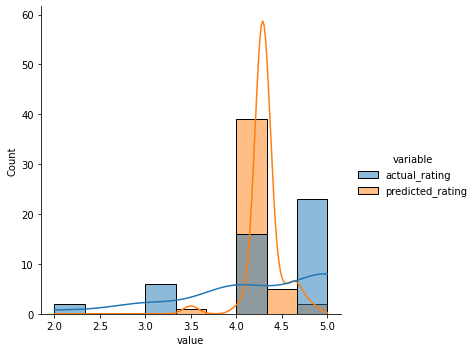

In [ ]:
predicted_ratings_for_interacted_items = predict_already_interacted_ratings(df,4, similarity_algo_optimized)
data = predicted_ratings_for_interacted_items.melt(id_vars='itemId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=data, x='value', hue='variable', kde=True);

**Comments:**

- The distribution of predicted ratings is closely following the distribution of actual ratings. The total bins for predicted ratings are nearly same as to the total bins for actual ratings.

- There are more predicted values in between 4 and 5, which is expected:
    - Actual ratings always have discreet values like 1, 2, 3, 4, 5, but predicted ratings can have continuous values because it is the aggregated ratings from the nearest neighbors of a given user. 

##### **Comparing the predicted ratings by `matrix factorization based recommendation` system against actual ratings for `userId=4`**

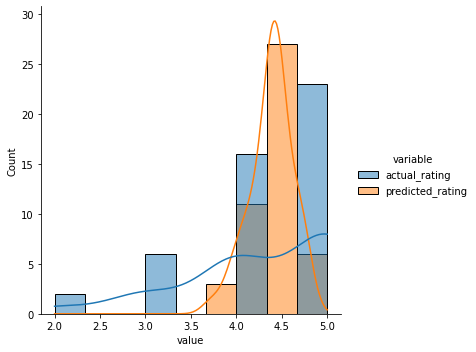

In [ ]:
predicted_ratings_for_interacted_items = predict_already_interacted_ratings(df,4, svd_algo_optimized)
data = predicted_ratings_for_interacted_items.melt(id_vars='itemId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=data, x='value', hue='variable', kde=True);

**Comments:**

- Same as in the previous cas, the distribution of predicted ratings is closely following the distribution of actual ratings. The total bins for predicted ratings are nearly same as to the total bins for actual ratings.

- There are more predicted values in between 4 and 5, which is expected because the actual ratings always have discreet values like 1, 2, 3, 4, 5, but predicted ratings can have continuous values. 

### **Precision and Recall @ k**
**Notes:**
 - Use precision and recall on additiontion RSME metrci.
 - The parameter k which is helpful in understanding problems with multiple rating outputs.

##### **Reading the data into the surprise data format and splitting into train and test sets**

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(electronics[['user_id', 'item_id', 'rating']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

##### **Computing the precision and recall, for each of the 6 models, at k = 5 and 10. This is 6 x 2 = 12 numerical values**

In [ ]:
from collections import defaultdict
# Function can be found on surprise documentation FAQs
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [ ]:
# Make list of k values
# A basic cross-validation iterator.
from surprise.model_selection import KFold
kf = KFold(n_splits=5)
K = [5, 10]

# Make list of models
models = [algo_knn_user, similarity_algo_optimized,algo_knn_item,similarity_algo_optimized_item, algo_svd, svd_algo_optimized]


for k in K:
    for model in models:
        print('> k={}, model={}'.format(k,model.__class__.__name__))
        p = []
        r = []
        for trainset, testset in kf.split(data):
            model.fit(trainset)
            predictions = model.test(testset, verbose=False)
            precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5)

            # Precision and recall can then be averaged over all users
            p.append(sum(prec for prec in precisions.values()) / len(precisions))
            r.append(sum(rec for rec in recalls.values()) / len(recalls))
        print('-----> Precision: ', round(sum(p) / len(p), 3))
        print('-----> Recall: ', round(sum(r) / len(r), 3))

> k=5, model=KNNBasic
-----> Precision:  0.868
-----> Recall:  0.685
> k=5, model=KNNBasic
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
-----> Precision:  0.86
-----> Recall:  0.704
> k=5, model=KNNBasic
-----> Precision:  0.835
-----> Recall:  0.661
> k=5, model=KNNBasic
-----> Precision:  0.84
-----> Recall:  0.689
> k=5, model=SVD
-----> Precision:  0.869
-----> Recall:  0.695
> k=5, model=SVD
-----> Precision:  0.871
-----> Recall:  0.698
> k=10, model=KNNBasic
-----> Precision:  0.855
-----> Recall:  0.862
> k=10, model=KNNBasic
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done co

**Comments:**
- Collaborative Filtering using user-user based interaction performed well for both when k=5 with an average precison around 86%, and when k=10 for an average precision of 84%

- Tuned SVD has better RMSE than all models but Collaborative Filtering using user-user based interaction also gave  good results based on Precsion and recall @k for K=10. 


##### **General Conclusions and Remarks:**

- First, the User-based RMSE values was 1.05 while the RMSE of the Item based model was 1.06. Therefore, the User-based and the Item-based Collaborative Models performed nearly the same.  

- Second, overall, all the Tuned Collaborative Filtering Models have performed better than the baseline models. Moreover, the user-user based tuned model performed better with a RMSE of 0.9887

- The Collaborative Models is a user/item-tailored model that uses the user-item-ratings data to find similarities and make predictions rather than just predicting a random rating based on the distribution of the data. This could be the reason why the Collaborative Filtering performed well.

- As for comparison and by definition, the Collaborative Filtering searches for neighbors based on similarity of item preferences and recommends items that those neighbors interacted. On the other hand, Matrix Factorization works by decomposing the user-item matrix into the product of two lower dimensionality rectangular matrices.

- As a result to the above bullet, the RMSE for Matrix Factorization, which was 0.92, is better than the Collaborative Filtering Models, which has and RMSE of approximatively 1.

- Tuning the SVD matrix factorization model did not improve the baseline SVD much. 

- Matrix Factorization has lower RMSE because it assumes that both items and users are present in some low dimensional space describing their properties and recommend an item based on its proximity to the user in the latent space.

## **REFERENCES:**
- Great Learning Post Graduate Program: MIT Data Science and Machine Learning: Make Data Driven decisions; Practice Project: https://www.mygreatlearning.com/mit-data-science-machine-learning-program
- k-NN inspired algorithms:  https://surprise.readthedocs.io/en/stable/knn_inspired.html
- Matrix Factorization-based algorithms: https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD
- How to get the top-N recommendations for each user: https://surprise.readthedocs.io/en/stable/FAQ.html
- Recall and Precision at k for Recommender Systems: https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54
- Amazon A/B Testing: https://aws.amazon.com/blogs/machine-learning/using-a-b-testing-to-measure-the-efficacy-of-recommendations-generated-by-amazon-personalize/